# Questions Automatic Tagging

This is the Capstone Project of my Udacity Machine Learning Nano Degree.

In this capstone project I will focus on one specific kind of problem among the many open problems in NLP: Text Classification. The task is to state what is the topic, among several availables, of a content expressed in natural language. To this end I will rely on the questions shared by Stack Exchange , take three classes of questions (i.e. cooking, robotics, biology) and try to create a model capable of stating to what of these three classes an unknown question belongs. After that I will try to create a model that for the questions of a given topic tries to predict what are the tags that best describe it. 

In [100]:
import pandas as pd
from bs4 import BeautifulSoup
import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


### Data Analysis

In [5]:
dataframes = {
    "cooking": pd.read_csv("cooking.csv"),
    "biology": pd.read_csv("biology.csv"),
    "robotics": pd.read_csv("robotics.csv")
}

In [6]:
dataframes['cooking']['class'] = 'cooking'
dataframes['biology']['class'] = 'biology'
dataframes['robotics']['class'] = 'robotics'

allquestions = pd.concat([dataframes['cooking'][:5000],dataframes['robotics'],dataframes['biology'][:5000]],
                        ignore_index=True)
#allquestions = allquestions.sample(frac=1)

In [7]:
print(dataframes["cooking"].iloc[1])
print(dataframes["robotics"].iloc[1])
print(dataframes["biology"].iloc[1])

id                                                         2
title                    How should I cook bacon in an oven?
content    <p>I've heard of people cooking bacon in an ov...
tags                                 oven cooking-time bacon
class                                                cooking
Name: 1, dtype: object
id                                                         2
title      How can I modify a low cost hobby servo to run...
content    <p>I've got some hobby servos (<a href="http:/...
tags                                         control rcservo
class                                               robotics
Name: 1, dtype: object
id                                                         2
title      How is RNAse contamination in RNA based experi...
content    <p>Does anyone have any suggestions to prevent...
tags                                        rna biochemistry
class                                                biology
Name: 1, dtype: object


(15404, 5)
['baking', 'food-safety', 'substitutions', 'equipment', 'bread']
[1444, 1211, 920, 816, 687]


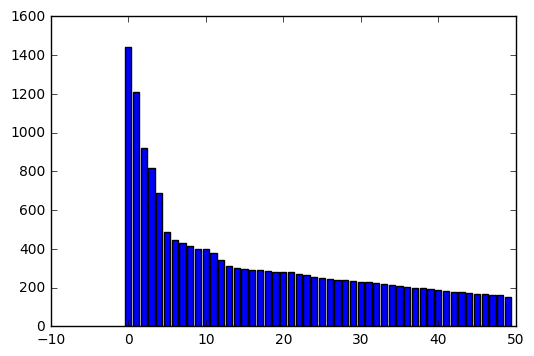

736


In [8]:
print(dataframes["cooking"].shape)
ctags = [ti for ta in dataframes["cooking"].tags for ti in ta.split() ]
cseries = pd.Series(ctags)
cus = cseries.unique()
counter = Counter(cseries)
counter = counter.most_common()
keys = [c[0] for c in counter][:50]
counts = [c[1] for c in counter][:50]
print(keys[:5])
print(counts[:5])
plt.bar(range(len(keys)), counts, align='center')
plt.show()
print(cus.size)

(2771, 5)
['quadcopter', 'mobile-robot', 'arduino', 'control', 'motor']
[306, 295, 282, 255, 239]


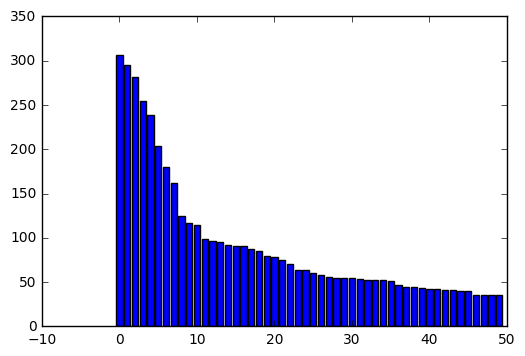

231


In [9]:
print(dataframes["robotics"].shape)
rtags = [ti for ta in dataframes["robotics"].tags for ti in ta.split() ]
rseries = pd.Series(rtags)
counter = Counter(rseries)
counter = counter.most_common()
keys = [c[0] for c in counter][:50]
counts = [c[1] for c in counter][:50]
print(keys[:5])
print(counts[:5])
rdf = pd.DataFrame(counter)
plt.bar(range(len(keys)), counts, align='center')
plt.show()
rus = rseries.unique()
print(rus.size)

(13196, 5)
['human-biology', 'genetics', 'evolution', 'biochemistry', 'molecular-biology']
[1448, 1229, 1159, 984, 863]


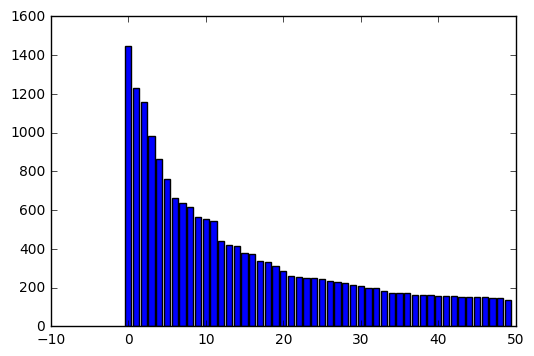

678


In [10]:
print(dataframes["biology"].shape)
btags = [ti for ta in dataframes["biology"].tags for ti in ta.split() ]
bseries = pd.Series(btags)
counter = Counter(bseries)
counter = counter.most_common()
keys = [c[0] for c in counter][:50]
counts = [c[1] for c in counter][:50]
print(keys[:5])
print(counts[:5])
plt.bar(range(len(keys)), counts, align='center')
plt.show()
bus = bseries.unique()
print(bus.size)

### Words Embedding

The first thing we have to do is transforming the input text into something that is machine readble which basically means numbers. 
We have to drop all the elemnts that do not provide relevant information. Since questions titles may contains html tags and uris we have to remove them. 

#### Preprocessing

In [56]:
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
def stripTagsAndUris(x):
    if x:
        soup = BeautifulSoup(x, "html.parser")
        if soup.code:
            soup.code.decompose()
        text =  soup.get_text()
        return re.sub(uri_re, "", text)
    else:
        return ""

In [57]:
def removePunctuation(x):
    x = x.lower()
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    return re.sub("["+string.punctuation+"]", " ", x)

In [58]:
stops = set(stopwords.words("english"))
def removeStopwords(x):
    filtered_words = [word for word in x.split() if word not in stops]
    return " ".join(filtered_words)

In [59]:
def textprep(_df):
    for df in _df.values():
        df["title"] = df["title"].map(removePunctuation)
        df["title"] = df["title"].map(removeStopwords)
        df["content"] = df["content"].map(removePunctuation)
        df["content"] = df["content"].map(removeStopwords)

In [60]:
textprep(dataframes)

In [210]:
print(dataframes["cooking"].iloc[1])

id                                           2
title                          cook bacon oven
content    how should i cook bacon in an oven 
tags                   oven cooking-time bacon
class                                  cooking
Name: 1, dtype: object


#### Bag of Words Model

The easiest approach is the so called Bag-of-words model where the text is represented by the set of words contained in it, loosing their order and thus disregarding the grammar or the syntax. Each word is paired with an integer representing the occurrencies of that word in the represented text. One of the weak aspect of this approach is that longer text may present more occurrencies of a given word, with respect to a shorter text, not because of its relevance but just because the text is longer. 

Since we rely in titles, which are short by construction, I think this aspect will not affect our task.

We rely on scikit learn CountVectorizer to transform words into numbers. We use a custom token pattern in order to catch words containing the '-' character like 'cooking-time'. 

In [20]:
c_title_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
c_tag_vectorizer   = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
r_title_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
r_tag_vectorizer   = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
b_title_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
b_tag_vectorizer   = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')

a_title_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
a_tag_vectorizer   = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')

c_titles = dataframes['cooking']['title']
r_titles = dataframes['robotics']['title']
b_titles = dataframes['biology']['title']

c_tags = dataframes['cooking']['tags']
r_tags = dataframes['robotics']['tags']
b_tags = dataframes['biology']['tags']

a_titles  = allquestions['title']
a_classes = allquestions['class']

print "vectorizing cooking titles"
c_X = c_title_vectorizer.fit_transform(c_titles)
print "vectorizing robotics titles"
r_X = r_title_vectorizer.fit_transform(r_titles)
print "vectorizing biology titles"
b_X = b_title_vectorizer.fit_transform(b_titles)

print "vectorizing cooking tags"
c_Y = c_tag_vectorizer.fit_transform(c_tags)
print "vectorizing robotics tags"
r_Y = r_tag_vectorizer.fit_transform(r_tags)
print "vectorizing biology tags"
b_Y = b_tag_vectorizer.fit_transform(b_tags)

print "vectorizing all titles"
a_X = a_title_vectorizer.fit_transform(a_titles)




vectorizing cooking titles
vectorizing robotics titles
vectorizing biology titles
vectorizing cooking tags
vectorizing robotics tags
vectorizing biology tags
vectorizing all titles


In [248]:
print(a_X[0])

  (0, 2573)	1
  (0, 1974)	1
  (0, 1990)	1
  (0, 1937)	1


#### n-grams model

A collection of single words like the bag-of-words fail capture phrases and expressions of multiple words. A more valuable approch is to consider single words along with sequences of adjcent words called n-grams. In this project we use bi-grams as a possible input model. Fortunately the CountVectorizer class can be configured to extract any range of ngram with the ngram_range(min,max) option.

In [213]:
ang_title_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2),
                                       token_pattern=r'\b\w\w+-?\w+\b')
print "vectorizing all titles with 2-grams"
a_X_2g = ang_title_vectorizer.fit_transform(a_titles)

vectorizing all titles with 3-grams


In [214]:
print(a_X_2g[0])

  (0, 8358)	1
  (0, 8419)	1
  (0, 8143)	1
  (0, 11082)	1
  (0, 8355)	1
  (0, 8405)	1
  (0, 8141)	1


#### Glove

A more sophisticated approach is to rely on vector space representations of words. Basically the idea is to exploit a previously created lookup table in which, for each word of our vocabulary, a vector of float valus corresponds. Their interesting property is that two words with similar meaning have similar vectors. These vectors are generally created automatically with a separated machine learning approach on big corpus of texts. 
In this project we rely on an already exsiting vector space called Glove.

https://nlp.stanford.edu/pubs/glove.pdf


https://nlp.stanford.edu/projects/glove/

In [84]:
w2v = {}
with open("glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

Here follows an example of what the pre-trained data can be used to retrieve vectors of values for each single word.

In [85]:
keys= w2v.keys()
print (w2v['ice'])

[-0.68163   1.1578   -0.47827   0.41421  -0.53186   0.63827  -0.90381
  0.50795   0.057398 -0.29163   1.1411   -0.079702  0.19951   1.1925
  0.52281   0.78633   0.78555   0.32624  -1.5504   -1.0191    0.35532
 -0.38875   0.92789   0.24325  -0.43162  -0.54939  -0.52209   1.0721
  0.99558  -0.38605   2.2673    0.41067  -0.08973   0.29741  -0.18678
  0.44329  -0.42243   0.80558   1.1306    0.14038  -0.089723  0.1341
  0.47948  -0.12774   0.024234  0.051782  0.44778  -0.47974  -0.62491
 -0.90005 ]


In [86]:
a_Xe = []
for title in a_titles:
    sentence = []
    for word in title.split():
        if word in w2v:
            wv = w2v[word]
            sentence.append(wv)
    words = [w for s in sentence for w in s]
    a_Xe.append(words)

In [87]:
maxdim = 0
for s in a_Xe:
    if len(s)>maxdim:
        maxdim = len(s)
print maxdim

1200


In [88]:
sentences =[]
for sent in a_Xe:
    padd = [0 for _ in range (maxdim - len(sent))]
    padd = np.asarray(padd)
    paddedsent = np.concatenate((sent,padd),axis=0)
    sentences.append(paddedsent)
a_Xe = sentences

In [89]:
print a_Xe[1]

[ 0.35145   -0.24155    0.0054776 ...,  0.         0.         0.       ]


# 1st Problem: Questions Classification

In this first problem I will try to create a model capable of stating, given an unknown question, to what class it belongs. I will try Naive Bayes and Random Forest on input data modeled through Bag of Words, n-grams (with n = 2) and word vectors (Glove). In the third case I will also try to train a Convolutional Neural Network. 

I will compare the obtained 7 models through the F1score metric.

### Using Bag of words

In [94]:
print a_X.shape

(12771, 12661)


In [95]:
X_train, X_test, y_train, y_test = train_test_split(a_X.toarray(), a_classes, test_size=0.3, random_state=42)

#### Naive Bayes Benchmark Model

In [96]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [97]:
idx = 351
print np.array(y_test)[idx]
print y_pred[idx]

biology
biology


In [98]:
fs1_1 = f1_score(np.array(y_test), y_pred, average='macro') 
print fs1_1

0.887763885977


#### Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy')
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [100]:
fs1_2 = f1_score(np.array(y_test), y_pred, average='macro') 
print fs1_2

0.877509953024


### Using 2-Grams

In [101]:
a_X_2g_array = a_X_2g.toarray()
print(a_X_2g_array.shape)
print(a_classes.shape)

(12771, 55882)
(12771,)


In [102]:
X3g_train, X3g_test, y3g_train, y3g_test = train_test_split(a_X_2g_array, a_classes, test_size=0.3, random_state=42)

#### Naive-Bayes Benchmark Model

In [257]:
gnb3 = GaussianNB()
y_pred = gnb3.fit(X3g_train, y3g_train).predict(X3g_test)

In [258]:
fs1_3 = f1_score(np.array(y3g_test), y_pred, average='macro') 
print fs1_3

0.896844697847


#### Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy')
y_pred = clf.fit(X3g_train, y3g_train).predict(X3g_test)

In [106]:
fs1_4 = f1_score(np.array(y3g_test), y_pred, average='macro') 
print fs1_4

0.878467432249


### Using Word Vectors

#### Naive Bayes Benchmark Model

In [221]:
cat_classes = a_classes.str.get_dummies()
#print cat_classes

In [239]:
X_train, X_test, y_train, y_test = train_test_split(a_Xe, a_classes, test_size=0.33, random_state=42)

In [223]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(a_Xe, cat_classes, test_size=0.33, random_state=42)

In [240]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [241]:
fs1_5 = f1_score(np.array(y_test), y_pred, average='macro') 
print fs1_5

0.149552249279


#### Random Forest

In [242]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy')
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [243]:
fs1_6 = f1_score(np.array(y_test), y_pred, average='macro') 
print fs1_6

0.707805926699


#### Convolutional Neural Network

In [230]:
from keras.models import Model,Sequential
from keras.layers.core import Reshape,Flatten,Dense
from keras.layers.convolutional import Convolution2D
from keras.models import load_model
from keras.layers.pooling import MaxPooling2D

try:
    model = load_model("cnn_nlp_5.h5")
except:
    print("Creating new Model")
    model = Sequential()
    model.add(Reshape((50,maxdim/50,1), input_shape=(maxdim,)))
    model.add(Convolution2D(16, 3, 3,activation='relu'))
    model.add(Convolution2D(16, 3, 3,activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Convolution2D(32, 3, 3,activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(3, activation ='softmax'))
    model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    
model.fit(np.array(Xc_train), np.array(yc_train), batch_size=32,verbose=1,nb_epoch=40)

Epoch 1/40
8556/8556 [==============================] - 13s - loss: 0.3970 - acc: 0.8319    
Epoch 2/40
8556/8556 [==============================] - 15s - loss: 0.3860 - acc: 0.8365    
Epoch 3/40
8556/8556 [==============================] - 14s - loss: 0.3733 - acc: 0.8375    
Epoch 4/40
8556/8556 [==============================] - 13s - loss: 0.3636 - acc: 0.8434    
Epoch 5/40
8556/8556 [==============================] - 14s - loss: 0.3514 - acc: 0.8511    
Epoch 6/40
8556/8556 [==============================] - 13s - loss: 0.3424 - acc: 0.8574    
Epoch 7/40
8556/8556 [==============================] - 15s - loss: 0.3318 - acc: 0.8620    
Epoch 8/40
8556/8556 [==============================] - 14s - loss: 0.3217 - acc: 0.8622    
Epoch 9/40
8556/8556 [==============================] - 15s - loss: 0.3111 - acc: 0.8717    
Epoch 10/40
8556/8556 [==============================] - 14s - loss: 0.3039 - acc: 0.8706    
Epoch 11/40
8556/8556 [==============================] - 14s - loss: 

In [231]:
model.save('cnn_nlp_5.h5')

In [236]:
y_pred = model.predict(np.array(Xc_test),batch_size=32,verbose=1)


4160/4215 [============================>.] - ETA: 0s

In [237]:
print y_pred[3].argmax()
_y_pred= []
for y in y_pred:
    r = y.argmax()
    if r ==0:
        _y_pred.append('biology')
    if r ==1:
        _y_pred.append('cooking')
    if r ==2:
        _y_pred.append('robotics')
print _y_pred[3]

2
robotics


In [238]:
fs1_7 = f1_score(np.array(y_test), _y_pred, average='macro') 
print fs1_7

0.765472738448


### Conclusions

In this first part of the capstone project I have investigated three different approches to transform input text into valuable inputs for machine learning algorithms: Bag-of-words, in which single words are taken, turned into integers and paired with the number of occurencies they have in each single sentence; 2-grams, in which the same thing is done for sequences of 2 words occurring in the same sentence; words vectors, in which any word is turned into a vector of floating values calculated trhough a previous automatic elebaboration of a corpus so that semantically similar words show similar vectors.

I have applied Naive Bayes and Random Forest for each Input model in order to see what combination performed better in classifing cooking, robotics and biology questions.

It turned out the best solution is Nayve Bayes trained on bi-grams.

In [244]:
result = [['Bag of Words','Naive Bayes',fs1_1],['Bag of Words','Random Forest',fs1_2],
          ['2_GRAMS','Naive Bayes',fs1_3],['2_GRAMS','Random Forest',fs1_4],
          ['WordVectors','Naive Bayes',fs1_5],['WordVectors','Random Forest',fs1_6],
          ['WordVectors','Conv. Neural Network',fs1_7]]
result = pd.DataFrame(result,columns=["Input Model","ML Model","Result"])
print result

    Input Model              ML Model    Result
0  Bag of Words           Naive Bayes  0.887764
1  Bag of Words         Random Forest  0.877510
2       2_GRAMS           Naive Bayes  0.896845
3       2_GRAMS         Random Forest  0.878467
4   WordVectors           Naive Bayes  0.149552
5   WordVectors         Random Forest  0.707806
6   WordVectors  Conv. Neural Network  0.765473


### Let's try the best model on my own questions

The trained model succeds in classifying made up questions.

In [266]:
def question_topic(q):
    q = removePunctuation(q)
    q = removeStopwords(q)
    q =  ang_title_vectorizer.transform([q])
    q = q.toarray()
    answer = gnb3.predict(q)
    return answer[0]

In [277]:
print question_topic('at what temperature should I bake bread?')
print question_topic('how high can a frog jump?')
print question_topic('how many cameras do I need to create a 3d image?')

cooking
biology
robotics


# 2nd Problem: Tagging Questions

Now we are going to focus on questions of a single topic and try to create a model capable of assigning tags to unknown questions.

In [74]:
robotics_questions = dataframes['robotics']['title']
robotics_questions.head()
print robotics_questions.shape

(2771,)


In [113]:
robotics_tags = dataframes['robotics']['tags']
rtags = [ti for ta in dataframes["robotics"].tags for ti in ta.split() ]
rseries = pd.Series(rtags)
counter = Counter(rseries)

In [114]:
counter = counter.most_common()
maxcount = 50
keys = [c[0] for c in counter][:maxcount]
counts = [c[1] for c in counter][:maxcount]

print keys[:5]
print counts[:5]
print counts[4]

count = 0
for c in counts:
    count=count+c
print count

['quadcopter', 'mobile-robot', 'arduino', 'control', 'motor']
[306, 295, 282, 255, 239]
239
4613


In [77]:
rc_tags_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\b\w\w+-?\w+\b')
rc_tags = rc_tags_vectorizer.fit_transform(r_tags)

#### Nouns Benchmark

As a simple benchmark model I am going to extract nouns and gerunds from questions and use them as possible tags. We rely on the pos_tag function (which means 'parts of speech tagging') of the nltk library to extract Nouns and Gerunds and see how this straightforward approach performs.

In [78]:
nn_titles = []
for i,title in enumerate(r_titles):
    pos = []
    pt_titl = nltk.pos_tag(word_tokenize(title))
    for pt in pt_titl:
        #print(pt)
        if pt[1]=='NN':
            pos.append(pt[0])
            #pos.append(pt[0]+'s')
        if pt[1]=='NNS':
            #pos.append(pt[0])
            pos.append(pt[0][:-1])
        if pt[1]=='VBG':# or pt[1]=='VBP' or pt[1]=='VBS':
            pos.append(pt[0])
    nn_titles.append(" ".join(pos))
nn_titles = [n.split() for n in nn_titles]

As the following example shows this approach is very simple but can provide interesting results we are now going to measure.

In [79]:
print nn_titles[0]
print r_tags[0].split()

['approach', 'spin', 'controller', 'soccer', 'robot']
['soccer', 'control']


In [80]:
vec_tags = []
for nl in nn_titles:
    vt = [0]*rc_tags.shape[1]
    for n in nl:
        if n in rc_tags_vectorizer.vocabulary_:
            vt[rc_tags_vectorizer.vocabulary_.get(n)]=1
    vec_tags.append(vt)

In [81]:
idx = 3
print "---"
print np.array(vec_tags[idx]).nonzero()
print np.array(rc_tags.toarray()[idx]).nonzero()
idx = 5
print "---"
print np.array(vec_tags[idx]).nonzero()
print np.array(rc_tags.toarray()[idx]).nonzero()
idx = 9
print "---"
print np.array(vec_tags[idx]).nonzero()
print np.array(rc_tags.toarray()[idx]).nonzero()

---
(array([123]),)
(array([ 10, 123, 164]),)
---
(array([193]),)
(array([148, 193]),)
---
(array([192]),)
(array([122, 192]),)


We get an average of 0.6 for the f1 score metrics

In [82]:
rc_tags_array = rc_tags.toarray()
_score = 0
for i,el in enumerate(rc_tags_array):
    _score+= f1_score(el,vec_tags[i], average='macro')
print(_score/rc_tags.shape[0])

0.608191533899


#### Convolutional Neural Network

Now we try to do something more sophisticated. We have seen word of vectors performed poorly with CNN for the first classification problem. I'd like now to create a CNN capable of tagging questions better that our NNs based approach (f1_score > 0.6) through word of vectors and I think an improvement could com from creating word vectors from titles' Nouns and Verbs only (avoiding any other POS TAG). 

Let's see if it works.

In [90]:
a_Xe = []
for title in nn_titles:
    sentence = []
    for word in title:
        if word in w2v:
            wv = w2v[word]
            sentence.append(wv)
    words = [w for s in sentence for w in s]
    a_Xe.append(words)

In [411]:
maxdim = 0
for s in a_Xe:
    if len(s)>maxdim:
        maxdim = len(s)
print maxdim

600


In [412]:
sentences =[]
for sent in a_Xe:
    padd = [0 for _ in range (maxdim - len(sent))]
    padd = np.asarray(padd)
    paddedsent = np.concatenate((sent,padd),axis=0)
    sentences.append(paddedsent)
a_Xe = sentences

In [415]:
r_Y_array = r_Y.toarray()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(a_Xe, r_Y_array, test_size=0.33, random_state=42)

In [420]:
print yc_train.shape
print np.array(Xc_train).shape

(1856, 230)
(1856, 600)


In [469]:
from keras.models import Model,Sequential
from keras.layers.core import Reshape,Flatten,Dense
from keras.layers.convolutional import Convolution2D
from keras.models import load_model
from keras.layers.pooling import MaxPooling2D

try:
    model = load_model("cnn_tags_2.h5")
except:
    print("Creating new Model")
    model = Sequential()
    model.add(Reshape((maxdim/50,50,1), input_shape=(maxdim,)))
    model.add(Convolution2D(16, 3, 3,activation='relu'))
    model.add(Convolution2D(16, 3, 3,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3,activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(230, activation ='softmax'))
    model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    
model.fit(np.array(Xc_train), np.array(yc_train), batch_size=32,verbose=1,nb_epoch=10)

Epoch 1/10
1856/1856 [==============================] - 4s - loss: 2.5415 - acc: 0.5474     
Epoch 2/10
1856/1856 [==============================] - 4s - loss: 2.5358 - acc: 0.5544     
Epoch 3/10
1856/1856 [==============================] - 4s - loss: 2.5310 - acc: 0.5453     
Epoch 4/10
1856/1856 [==============================] - 4s - loss: 2.5200 - acc: 0.5528     
Epoch 5/10
1856/1856 [==============================] - 4s - loss: 2.5234 - acc: 0.5673     
Epoch 6/10
1856/1856 [==============================] - 4s - loss: 2.5075 - acc: 0.5544     
Epoch 7/10
1856/1856 [==============================] - 4s - loss: 2.5049 - acc: 0.5673     
Epoch 8/10
1856/1856 [==============================] - 4s - loss: 2.5017 - acc: 0.5463     
Epoch 9/10
1856/1856 [==============================] - 4s - loss: 2.4998 - acc: 0.5506     
Epoch 10/10
1856/1856 [==============================] - 4s - loss: 2.4901 - acc: 0.5388     


In [470]:
model.save("cnn_tags_2.h5")

In [ ]:
y_pred = model.predict(np.array(Xc_test),batch_size=32,verbose=1)

In [501]:
def getWord(_idx):
    for word,idx in r_tag_vectorizer.vocabulary_.iteritems():
        if idx == _idx:
            return word

In [502]:
_y_pred= []
for y in y_pred:
    ny = [0]*len(y)
    for i,v in enumerate(y):
        if v > 0.1:
            ny[i]=1
    _y_pred.append(ny)

In [503]:
print len(yc_test[0])
print len(y_pred[0])

_score = 0
for i,el in enumerate(_y_pred):
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/rc_tags.shape[0])

230
230
0.195349315056


I trained the CNN for 40 epochs and the final average f1_score result is about 0.2. I will try with a bi-grams input model.

#### trying with bi-grams

In [91]:
r3g_title_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2),
                                       token_pattern=r'\b\w\w+-?\w+\b')
print "vectorizing robotics titles with 2-grams"
r_X_3g = r3g_title_vectorizer.fit_transform(r_titles)

vectorizing robotics titles with 2-grams


In [92]:
r_Y_array = r_Y.toarray()
r_X_3g_array = r_X_3g.toarray()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(r_X_3g_array, r_Y_array, test_size=0.33, random_state=42)

In [93]:
from keras.models import Model,Sequential
from keras.layers.core import Reshape,Flatten,Dense
from keras.layers.convolutional import Convolution1D
from keras.models import load_model
from keras.layers.pooling import MaxPooling2D
from keras.layers.embeddings import Embedding

maxdim = Xc_train.shape[1]
try:
    model = load_model("cnn_tags_3g_1.h5")
except:
    print("Creating new Model")
    model = Sequential()
    model.add(Embedding(maxdim,15,input_length=maxdim))
    model.add(Convolution1D(16, 3,activation='relu'))
    model.add(Convolution1D(16, 3,activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(230, activation ='softmax'))
    model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    
model.fit(np.array(Xc_train), np.array(yc_train), batch_size=32,verbose=1,nb_epoch=10)

Using TensorFlow backend.


Epoch 1/10
1856/1856 [==============================] - 97s - loss: 2.3694 - acc: 0.5722    
Epoch 2/10
1856/1856 [==============================] - 95s - loss: 2.3681 - acc: 0.5560    
Epoch 3/10
1856/1856 [==============================] - 103s - loss: 2.3587 - acc: 0.5717   
Epoch 4/10
1856/1856 [==============================] - 94s - loss: 2.3556 - acc: 0.5603    
Epoch 5/10
1856/1856 [==============================] - 91s - loss: 2.3507 - acc: 0.5733    
Epoch 6/10
1856/1856 [==============================] - 100s - loss: 2.3447 - acc: 0.5663   
Epoch 7/10
1856/1856 [==============================] - 103s - loss: 2.3483 - acc: 0.5609   
Epoch 8/10
1856/1856 [==============================] - 95s - loss: 2.3404 - acc: 0.5496    
Epoch 9/10
1856/1856 [==============================] - 110s - loss: 2.3348 - acc: 0.5684   
Epoch 10/10
1856/1856 [==============================] - 109s - loss: 2.3337 - acc: 0.5700   


In [94]:
model.save("cnn_tags_3g_1.h5")

In [95]:
y_pred = model.predict(np.array(Xc_test),batch_size=32,verbose=1)

915/915 [==============================] - 9s     


In [96]:
_y_pred= []
for y in y_pred:
    ny = [0]*len(y)
    for i,v in enumerate(y):
        if v > 0.16:
            ny[i]=1
    _y_pred.append(ny)

In [97]:
print len(yc_test[0])
print len(y_pred[0])

_score = 0
for i,el in enumerate(_y_pred):
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(_y_pred))

230
230
0.617673068191


the obtaind result is very similar to previous one meaning the bi-grams input model didn't affect the performance. I will try with random forest.

#### back to Random Forest

In [98]:
print Xc_train.shape
print yc_train.shape

(1856, 13343)
(1856, 230)


In [101]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy')
y_pred = clf.fit(Xc_train, yc_train).predict(Xc_test)

In [102]:
_y_pred= []
for y in y_pred:
    ny = [0]*len(y)
    for i,v in enumerate(y):
        if v > 0.16:
            ny[i]=1
    _y_pred.append(ny)

In [104]:
print len(yc_test[0])
print len(y_pred[0])

_score = 0
for i,el in enumerate(_y_pred):
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(_y_pred))

230
230
0.590164411529


Again the result is about 0.2. Are we dealing with too much tags? Considering how unbalanced the tags are we might have better results if we focused on the most relevant 50 tags.

#### Trying reducing tags and deal with the 50 most relevant

In [115]:
r_top50_tags = []
for tags in r_tags:
    nr = ''
    for tag in word_tokenize(tags):
        if tag in keys:
            nr+=tag+' '
    r_top50_tags.append(nr)

In [116]:
np.array(r_top50_tags)

array(['control ', 'control rcservo ', '', ..., 'arduino raspberry-pi ',
       'slam ekf ', ''], 
      dtype='|S76')

In [117]:
r_50tag_vectorizer = CountVectorizer(stop_words='english',
                                       token_pattern=r'\b\w\w+-?\w+\b')
r_top50_tags = r_50tag_vectorizer.fit_transform(np.array(r_top50_tags))

In [118]:
r_top50_tags.shape

(2771, 50)

In [119]:
print keys

['quadcopter', 'mobile-robot', 'arduino', 'control', 'motor', 'sensors', 'robotic-arm', 'pid', 'localization', 'microcontroller', 'slam', 'ros', 'raspberry-pi', 'irobot-create', 'wheeled-robot', 'design', 'kinematics', 'kalman-filter', 'computer-vision', 'imu', 'motion-planning', 'inverse-kinematics', 'mechanism', 'brushless-motor', 'battery', 'power', 'cameras', 'stepper-motor', 'electronics', 'accelerometer', 'navigation', 'software', 'kinect', 'servos', 'algorithm', 'gyroscope', 'actuator', 'matlab', 'dynamics', 'ekf', 'servomotor', 'sensor-fusion', 'torque', 'mapping', 'esc', 'rcservo', 'industrial-robot', 'gps', 'odometry', 'stereo-vision']


In [120]:
r_Y_array = r_top50_tags.toarray()
r_X_3g_array = r_X_3g.toarray()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(r_X_3g_array, r_Y_array, test_size=0.33, random_state=42)

In [121]:
maxdim = Xc_train.shape[1]
try:
    model = load_model("cnn_50tags_3g_1.h5")
except:
    print("Creating new Model")
    model = Sequential()
    model.add(Embedding(maxdim,15,input_length=maxdim))
    model.add(Convolution1D(16, 3,activation='relu'))
    model.add(Convolution1D(16, 3,activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(50, activation ='softmax'))
    model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    
model.fit(np.array(Xc_train), np.array(yc_train), batch_size=32,verbose=1,nb_epoch=10)

Epoch 1/10
1856/1856 [==============================] - 44s - loss: 1.3097 - acc: 0.5954    
Epoch 2/10
1856/1856 [==============================] - 40s - loss: 1.3038 - acc: 0.6099    
Epoch 3/10
1856/1856 [==============================] - 44s - loss: 1.3025 - acc: 0.5900    
Epoch 4/10
1856/1856 [==============================] - 40s - loss: 1.2994 - acc: 0.6040    
Epoch 5/10
1856/1856 [==============================] - 38s - loss: 1.2986 - acc: 0.5948    
Epoch 6/10
1856/1856 [==============================] - 38s - loss: 1.2936 - acc: 0.6045    
Epoch 7/10
1856/1856 [==============================] - 38s - loss: 1.2913 - acc: 0.5938    
Epoch 8/10
1856/1856 [==============================] - 39s - loss: 1.2905 - acc: 0.6126    
Epoch 9/10
1856/1856 [==============================] - 40s - loss: 1.2868 - acc: 0.5997    
Epoch 10/10
1856/1856 [==============================] - 38s - loss: 1.2851 - acc: 0.6002    


In [122]:
model.save('cnn_50tags_3g_1.h5')

In [123]:
cnn_model = model

In [124]:
y_pred = model.predict(np.array(Xc_test),batch_size=32,verbose=1)

915/915 [==============================] - 7s     


In [125]:
_y_pred= []
for y in y_pred:
    ny = [0]*len(y)
    for i,v in enumerate(y):
        if v > 0.16:
            ny[i]=1
    _y_pred.append(ny)

In [127]:
print len(yc_test[0])
print len(y_pred[0])

_score = 0
for i,el in enumerate(_y_pred):
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(_y_pred))

50
50
0.640445560283


#### top 50 with random forest

In [128]:
clf = RandomForestClassifier(n_estimators=50,criterion='entropy')
y_pred = clf.fit(Xc_train, yc_train).predict(Xc_test)

In [129]:
_y_pred= []
for y in y_pred:
    ny = [0]*len(y)
    for i,v in enumerate(y):
        if v > 0.16:
            ny[i]=1
    _y_pred.append(ny)

In [131]:
print len(yc_test[0])
print len(y_pred[0])

_score = 0
_ascore =0
for i,el in enumerate(_y_pred):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_ascore/len(_y_pred))
print(_score/len(_y_pred))

50
50
0.970754098361
0.653152914879


### SVM

In [132]:
nn_titles = [" ".join(n) for n in nn_titles]
rnn_title_vectorizer = CountVectorizer(stop_words='english',
                                       token_pattern=r'\b\w\w+-?\w+\b')
rnn_X = rnn_title_vectorizer.fit_transform(nn_titles)

In [133]:
r_Y_array = r_top50_tags.toarray()
rnn_X_array = rnn_X.toarray()
Xc_train, Xc_test, yc_train, yc_test,idx1,idx2 = train_test_split(rnn_X_array, r_Y_array,range(rnn_X_array.shape[0]), test_size=0.33, random_state=42)

In [134]:
print r_Y_array.shape

(2771, 50)


In [135]:
svm_y = []
for t in range(yc_train.shape[1]):
    vec = [yc_train[q,t] for q in range(yc_train.shape[0])]
    svm_y.append(vec)
svm_y = np.array(svm_y)
print svm_y.shape

(50, 1856)


In [136]:
from sklearn import svm
svm_array = []
for t in range(yc_train.shape[1]):
    print t,
    clf = svm.LinearSVC()
    clf.fit(Xc_train, svm_y[t])
    svm_array.append(clf)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [137]:
from sklearn import svm
gnb_array = []
for t in range(yc_train.shape[1]):
    print t,
    clf = GaussianNB()
    clf.fit(Xc_train, svm_y[t])
    gnb_array.append(clf)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [138]:
out1 = []
for cl in svm_array:
    print '*',
    y_pred = cl.predict(Xc_test)
    out1.append(y_pred)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [1029]:
out1 = []
for cl in gnb_array:
    print '*',
    y_pred = cl.predict(Xc_test)
    out1.append(y_pred)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [139]:
out1 = np.array(out1)
print out1.shape
res = []
for q in range(out1.shape[1]):
    vec = [out1[t,q] for t in range(out1.shape[0])]
    res.append(vec)
res = np.array(res)
print res.shape

(50, 915)
(915, 50)


In [140]:
_score = 0
_ascore =0
for i,el in enumerate(res):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(res))
print(_ascore/len(res))

0.66424619993
0.96625136612


### hybrid approach

Here is a possible hybrid approach: 

1. we take the list of nouns and gerunds for each questiontitle and contnt and keep only those included in the top 50 tags;
2. we use the array of SVMs and GNBs to predict the remaining tags



In [141]:
#print dataframes['robotics']['content'][0]
y_content = [dataframes['robotics']['content'][idx] for idx in idx2]
nn_content = []
for i,content in enumerate(y_content):
    pos = []
    pt_cont = nltk.pos_tag(word_tokenize(content))
    for pt in pt_cont:
        #print(pt)
        if pt[0] in keys:
            pos.append(pt[0])
    pos = pd.Series(pos).unique()
    nn_content.append(pos)
#nn_content = [n.split() for n in nn_content]
nn_content = pd.Series(nn_content)
print nn_content[1]

['torque' 'motor']


In [142]:
nn_content[3]

array([], dtype=float64)

In [143]:
extracted = []
y_titles = [nn_titles[idx] for idx in idx2]
for nt in y_titles:
    filtered = []
    for n in nt.split():
        if n in keys:
            filtered.append(n)
    extracted.append(filtered)

idx = 1
print y_titles[idx]
print extracted[idx]        

gear ratio motor
['motor']


In [144]:
extracted = [" ".join(e) for e in extracted]
c_extracted = [" ".join(c) for c in nn_content]
extr_vec = r_50tag_vectorizer.transform(extracted)
c_extr_vec = r_50tag_vectorizer.transform(c_extracted)

In [145]:
print c_extr_vec[0]

  (0, 31)	1
  (0, 39)	1
  (0, 41)	1


In [146]:
predicted = []
predicted2 = []

for cl in svm_array:
    print '*',
    y_pred = cl.predict(Xc_test)
    predicted.append(y_pred)

for c2 in gnb_array:
    print '*',
    y_pred = c2.predict(Xc_test)
    predicted2.append(y_pred)

    

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [147]:
idx = 5
predictions = []
for idx,el in enumerate(predicted):
    pred = [x for x in el.nonzero()[0] if x in predicted2[idx].nonzero()[0]]
    predictions.append(pred)

    pred_array = []
for qi in range(yc_test.shape[0]):
    tags = [0]*yc_test.shape[1]
    pred_array.append(tags)
pred_array = np.array(pred_array)

for tag,pred in enumerate(predictions):
    for p in pred:
        pred_array[pred,tag]=1

ext_array = extr_vec.toarray()
c_ext_array = c_extr_vec.toarray()
print len(ext_array)
for idx,e in enumerate(ext_array):
    pred_array[idx] = pred_array[idx]|e
for idx,c in enumerate(c_ext_array):
    pred_array[idx] = pred_array[idx]|c
    
print pred_array[6]

915
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [148]:
_score = 0
_ascore =0
for i,el in enumerate(pred_array):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(pred_array))
print(_ascore/len(pred_array))

0.691286696385
0.956765027322


Through this hybrid approach we have manged to score 0.23 of F1 still from the 0.3 objective.

### Using Bi-grams

In [42]:
r_tags.head()
ncounter = Counter(rseries)
ncounter = ncounter.most_common()
maxcount = 100
nkeys = [c[0] for c in ncounter][:maxcount]
ncounts = [c[1] for c in ncounter][:maxcount]

In [43]:
r_top_tags = []
for tags in r_tags:
    nr = ''
    for tag in word_tokenize(tags):
        if tag in nkeys:
            nr+=tag+' '
    r_top_tags.append(nr)

In [44]:
print np.array(nkeys).shape

(100,)


In [45]:
r2g_title_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2),
                                       token_pattern=r'\b\w\w+-?\w+\b')
print "vectorizing robotics titles with 2-grams"
r_X_2g = r2g_title_vectorizer.fit_transform(r_titles)

vectorizing robotics titles with 2-grams


In [46]:
print r_X_2g.toarray()

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [47]:
#r_Y = r_tag_vectorizer.fit_transform(r_tags)
r_top_tag_vectorizer = CountVectorizer(stop_words='english',
                                       token_pattern=r'\b\w\w+-?\w+\b')
r_top_tags = r_top_tag_vectorizer.fit_transform(np.array(r_top_tags))

r_y_array = r_top_tags.toarray()

In [48]:
Xc_train, Xc_test, yc_train, yc_test= train_test_split(r_X_2g.toarray(), r_y_array, test_size=0.33, random_state=42)

In [49]:
svm_y = []
for t in range(yc_train.shape[1]):
    vec = [yc_train[q,t] for q in range(yc_train.shape[0])]
    svm_y.append(vec)
svm_y = np.array(svm_y)
print svm_y.shape

(98, 1856)


In [50]:
from sklearn import svm
svm_array = []
for t in range(yc_train.shape[1]):
    print t,
    clf = svm.LinearSVC()
    clf.fit(Xc_train, svm_y[t])
    svm_array.append(clf)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97


In [51]:
out1 = []
for cl in svm_array:
    print '*',
    y_pred = cl.predict(Xc_test)
    out1.append(y_pred)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [52]:
out1 = np.array(out1)
print out1.shape
res = []
for q in range(out1.shape[1]):
    vec = [out1[t,q] for t in range(out1.shape[0])]
    res.append(vec)
res = np.array(res)
print res.shape

(98, 915)
(915, 98)


In [53]:
_score = 0
_ascore =0
for i,el in enumerate(res):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(res))
print(_ascore/len(res))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.659831901215
0.9818779971


### Trying with Title and Content POS Tags

In [54]:
nn_titles = []
for i,title in enumerate(r_titles):
    pos = []
    pt_titl = nltk.pos_tag(word_tokenize(title))
    for pt in pt_titl:
        #print(pt)
        if pt[1]=='NN':
            pos.append(pt[0])
            #pos.append(pt[0]+'s')
        if pt[1]=='NNS':
            #pos.append(pt[0])
            pos.append(pt[0][:-1])
        if pt[1]=='VBG':# or pt[1]=='VBP' or pt[1]=='VBS':
            pos.append(pt[0])
    nn_titles.append(" ".join(pos))
nn_titles = [n.split() for n in nn_titles]
print nn_titles[0]

['approach', 'spin', 'controller', 'soccer', 'robot']


In [61]:
#print dataframes['robotics']['content'][0]
contents = dataframes['robotics']['content']
nn_content = []
for i,content in enumerate(contents):
    pos = []
    pt_cont = nltk.pos_tag(word_tokenize(content))
    for pt in pt_cont:
        #print(pt)
        tmp = pt[0]
        if pt[1]=='NNS':
            tmp =  pt[0][:-1]
        if tmp in nkeys:
            pos.append(tmp)
    
    pos = pd.Series(pos).unique()
    nn_content.append(" ".join(pos))
nn_contents = [n.split() for n in nn_content]
print nn_contents[0]

['wheel', 'pid', 'motor', 'servos', 'software', 'movement', 'pwm']


In [62]:
print dataframes['robotics']['title'][0]
print dataframes['robotics']['content'][0]
print nn_titles[0]
print nn_contents[0]

right approach write spin controller soccer robot
p imagine programming 3 wheel soccer robot type controller would use spinning p pid p p goal controller make robot stand defined angle 0 degree turn back rotated hand robot p p use stepper motors robot servos need implement software p p written sample p type controller already movement fairly good would like make better possible code follows p pre code void spinspeed int devidedvalue int addedvalue int correction degree lt correction amp amp degree gt correction motorspeed 0 else degree gt 0 motorspeed degree devidedvalue addedvalue else motorspeed degree devidedvalue addedvalue code pre p code correction code range robot movement code degree code number 127 128 returned compass code motorspeed code number 0 255 applied pwm p
['approach', 'spin', 'controller', 'soccer', 'robot']
['wheel', 'pid', 'motor', 'servos', 'software', 'movement', 'pwm']


In [63]:
nn_contents = [" ".join(c) for c in nn_contents]

In [64]:
nn_titles = [" ".join(c) for c in nn_titles]

In [65]:
print nn_titles[0]
print nn_contents[0]
nn_tandc = []
for idx,t in enumerate(nn_titles):
    tmp = t+nn_contents[idx]
    nn_tandc.append(tmp)
print nn_tandc[0]

approach spin controller soccer robot
wheel pid motor servos software movement pwm
approach spin controller soccer robotwheel pid motor servos software movement pwm


In [66]:
r_content_vectorizer = CountVectorizer(stop_words='english',
                                       token_pattern=r'\b\w\w+-?\w+\b')
r_X = r_content_vectorizer.fit_transform(nn_tandc)

In [67]:
Xc_train, Xc_test, yc_train, yc_test= train_test_split(r_X.toarray(), r_y_array, test_size=0.33, random_state=42)

In [68]:
svm_y = []
for t in range(yc_train.shape[1]):
    vec = [yc_train[q,t] for q in range(yc_train.shape[0])]
    svm_y.append(vec)
svm_y = np.array(svm_y)
print svm_y.shape

(98, 1856)


In [69]:
from sklearn import svm
svm_array = []
for t in range(yc_train.shape[1]):
    print t,
    clf = svm.LinearSVC()
    clf.fit(Xc_train, svm_y[t])
    svm_array.append(clf)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97


In [70]:
out1 = []
for cl in svm_array:
    print '*',
    y_pred = cl.predict(Xc_test)
    out1.append(y_pred)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [71]:
out1 = np.array(out1)
print out1.shape
res = []
for q in range(out1.shape[1]):
    vec = [out1[t,q] for t in range(out1.shape[0])]
    res.append(vec)
res = np.array(res)
print res.shape

(98, 915)
(915, 98)


In [72]:
_score = 0
_ascore =0
for i,el in enumerate(res):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(res))
print(_ascore/len(res))

0.61200735316
0.978275900524


### Trying all Tags with SVM

In [26]:
r2g_title_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2),
                                       token_pattern=r'\b\w\w+-?\w+\b')
print "vectorizing robotics titles with 2-grams"
r_X_2g = r2g_title_vectorizer.fit_transform(r_titles)
r_X_2t_array = r_X_2g.toarray()

vectorizing robotics titles with 2-grams


In [27]:
r_Y = r_tag_vectorizer.fit_transform(r_tags)
r_Y_array = r_Y.toarray()

In [28]:
Xc_train, Xc_test, yc_train, yc_test= train_test_split(r_X_2g.toarray(), r_Y_array, test_size=0.33, random_state=42)

In [29]:
svm_y = []
for t in range(yc_train.shape[1]):
    vec = [yc_train[q,t] for q in range(yc_train.shape[0])]
    svm_y.append(vec)
svm_y = np.array(svm_y)
print svm_y.shape

(230, 1856)


In [30]:
from sklearn import svm
svm_array = []
for t in range(yc_train.shape[1]):
    print t,
    clf = svm.SVC()
    try:
        clf.fit(Xc_train, svm_y[t])
        svm_array.append(clf)
    except:
        svm_array.append(None)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229


In [32]:
out1 = []
for cl in svm_array:
    print '*',
    if cl is not None:
        y_pred = cl.predict(Xc_test)
    else:
        y_pred = [0]*Xc_test.shape[0]
    out1.append(y_pred)
    

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [37]:
out1 = np.array(out1)
print out1.shape
res = []
for q in range(out1.shape[1]):
    vec = [out1[t,q] for t in range(out1.shape[0])]
    res.append(vec)
res = np.array(res)
print res.shape

(230, 915)
(915, 230)


In [38]:
_score = 0
_ascore =0
for i,el in enumerate(res):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(res))
print(_ascore/len(res))

0.497963902119
0.989736279401


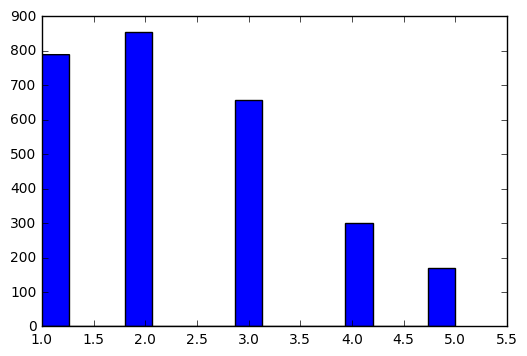

In [25]:
r_tags_histo = [len(ttt.split()) for ttt in r_tags]
plt.hist(r_tags_histo, bins='auto')
plt.show()

In [33]:
out1 = np.array(out1)
print out1.shape
res = []
for q in range(out1.shape[1]):
    vec = [out1[t,q] for t in range(out1.shape[0])]
    for idx,v in enumerate(vec):
        maxtags = 2
        if v==1:
            maxtags = maxtags-1
            if maxtags ==0:
                v=0
        vec[idx]=v
    res.append(vec)
res = np.array(res)
print res.shape


(230, 915)
(915, 230)


In [36]:
_score = 0
_ascore =0
for i,el in enumerate(res):
    _ascore += accuracy_score(yc_test[i], el)
    _score+= f1_score(yc_test[i],el, average='macro')
print(_score/len(res))
print(_ascore/len(res))

0.497963902119
0.989736279401


#### 